In [1]:
import os
import glob
from PIL import Image
import numpy as np
import cv2
import shapely
import tqdm

from pycocotools.coco import COCO
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
yolo_path = '/home/ibragim/data/siz_segment'
ann_path = os.path.join(yolo_path, 'annotations')
os.makedirs(ann_path, exist_ok=True)

In [3]:
info= {
    "description": "COCO 2017 Dataset",
    "url": "",
    "version": "1.0",
    "year": 2024,
    "contributor": "Ailab",
    "date_created": "2024/04/01"
}

In [234]:
categories = {1: {'id': 1, 'name': 'Vehicle', 'supercategory': ''}}

In [242]:
categories = {1: {'id': 1, 'name': 'Karyeri', 'supercategory': ''}}

In [5]:
categories = {1: {'id': 1, 'name': 'Oil', 'supercategory': ''}}

In [5]:
categories = {1: {'id': 1, 'name': 'Oil', 'supercategory': ''},
 2: {'id': 2, 'name': 'Salt', 'supercategory': ''},}

In [4]:
categories = {1: {'id': 1, 'name': 'Hardhat', 'supercategory': ''},
 2: {'id': 2, 'name': 'No-Hardhat', 'supercategory': ''},
 3: {'id': 3, 'name': 'Safety Jacket', 'supercategory': ''},
 4: {'id': 4, 'name': 'NO-Safety Jacket', 'supercategory': ''},
 5: {'id': 5, 'name': 'Safety Pants', 'supercategory': ''},
 6: {'id': 6, 'name': 'NO-Safety Pants', 'supercategory': ''},
 7: {'id': 7, 'name': 'BagGasMask', 'supercategory': ''},}

In [6]:
import PIL.ExifTags

images = {}
annotations = {}
image_id = 1
ann_id = 1

names_to_redo = []
train_val = 'train'
pbar = tqdm.tqdm(glob.glob(yolo_path+f'/images/{train_val}/*'))
for i in pbar:
    pbar.set_description(os.path.basename(i))
    
#     with Image.open(i) as img:
#         height_p, width_p = img.height, img.width
#         exif = {
#             PIL.ExifTags.TAGS[k]: v
#             for k, v in img._getexif().items()
#             if k in PIL.ExifTags.TAGS
#         }
#         break
#     print(i)
    height, width = cv2.imread(i).shape[:2]
    file_name = os.path.basename(i)

#     height, width =  width_p, height_p
    images[image_id] = {'id':image_id, 'height': height, 'width': width, 'file_name': file_name, 'license':0, 'flickr_url':'', 'coco_url':'', 'date_captured':0}
    with open(i.replace('images','labels')[:-4]+'.txt') as lbl:
        lines = lbl.readlines()
        for l in lines:
            l_spl = l.split(' ')
            cls, coords = l_spl[0], l_spl[1:]
            coords = [float(s) for s in coords if s != '']
            coords = np.array(coords)
            coords[::2] *= width
            coords[1::2] *= height
#             if exif['Orientation']==6:
#                 coords2 = coords.copy()
#                 coords[::2], coords[1::2] = coords2[1::2], coords2[::2]
            # coords = np.array(coords).reshape(-1, 2) * np.array([width, height])
            poly = shapely.Polygon(coords.reshape(-1, 2)).buffer(0.0)
            if poly.geom_type != 'Polygon':
                names_to_redo.append(file_name)
                print(image_id, file_name,  int(cls)+1, poly.geom_type, image_id)
                for pol in list(poly.geoms):
                    if not pol.is_valid:
                        pol= pol.convex_hull
                    if pol.area>20:
                        x,y,x2,y2= pol.bounds
                        annotations[ann_id] = {'id': ann_id, 'image_id':image_id, 'category_id':int(cls)+1, 'segmentation':[np.array(pol.exterior.coords).flatten().tolist()], 'area':pol.area, 'bbox':[x,y,x2-x, y2-y], 'iscrowd':0, 'attributes': {'occluded': False}}
                        ann_id+=1
            else:            
                if not poly.is_valid:
                    poly= poly.convex_hull
                    print(image_id, i)
                x,y,x2,y2= poly.bounds
                annotations[ann_id] = {'id': ann_id, 'image_id':image_id, 'category_id':int(cls)+1, 'segmentation':[np.array(poly.exterior.coords).flatten().tolist()], 'area':poly.area, 'bbox':[x,y,x2-x, y2-y], 'iscrowd':0, 'attributes': {'occluded': False}}
                ann_id+=1
    image_id+=1
    
import json
with open(os.path.join(ann_path,f'{train_val}.json'),'w') as f:  
    final = {'licenses': [],
             'info': info,
             'categories': list(categories.values()),
             'images': list(images.values()),
             'annotations': list(annotations.values())}  
    json.dump(final, f)


260424_2_60.JPG: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 447/447 [01:08<00:00,  6.54it/s]


In [8]:
names_to_redo= set(names_to_redo)
print(len(names_to_redo))

0


In [8]:
names_to_redo


{'020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_0041.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_0065.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_0141.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_0489.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_0490.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_0724.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_0943.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_0945.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_20230511150951_0014_V.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_20230617143034_0048_V.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_20230629161626_0045_V.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_20230705154140_0007_V.JPG',
 '020823_summer_Tatneft_siz_bws_SIZ_summer_020823_DJI_20230705160025_0122_V.JPG',
 '070623_winter_Tatneft_siz_bws_SIZ_winter_070623.JPG',
 '070623_winte

In [12]:

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """

    for c in range(3):
        if alpha >= 0:
            image[:, :, c] = np.where(
#                 mask == 1,
#                 image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
#                 image[:, :, c]
                mask > 0,
                (image[:, :, c] * (1 - alpha) + color[c] * 255 * alpha) * mask,
                image[:, :, c]
            )
        else:
            image[:, :, c] = np.where(
                mask > 0,
                image[:, :, c] + color[c] * 255,
                image[:, :, c]
            )
    return image

In [99]:
for i in images.values():
    if 'DSC00290' in i['file_name']:
        print(i)

In [13]:
print(os.path.join(ann_path,f'{train_val}.json'))

/home/ibragim/data/siz_segment/annotations/train.json


In [14]:
coco = COCO(os.path.join(ann_path,f'{train_val}.json'))

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [198]:
coco.cats

{1: {'id': 1, 'name': 'Oil', 'supercategory': ''},
 2: {'id': 2, 'name': 'Salt', 'supercategory': ''}}

In [199]:
for i in coco.anns:
    print(i)
    break

1


In [171]:
name_13 = 'DJI_0060 (2)_2023-07-10_13-13-32.JPG'

In [173]:
for a in coco.anns:
    i = coco.loadAnns(a)
    if i[0]['category_id']==2:
        print(i)
        break

[{'id': 10, 'image_id': 2, 'category_id': 2, 'segmentation': [[4529.048000000001, 3612.0600000000004, 4527.736, 3601.602, 4526.44, 3591.798, 4528.400000000001, 3581.34, 4532.320000000001, 3572.19, 4533.616, 3562.3799999999997, 4529.048000000001, 3552.582, 4527.736, 3542.118, 4528.400000000001, 3531.672, 4529.704, 3521.8619999999996, 4536.888, 3514.668, 4546.04, 3510.75, 4555.848, 3511.398, 4565.648, 3509.4419999999996, 4568.272, 3499.6380000000004, 4565.0, 3489.84, 4561.727999999999, 3480.0299999999997, 4559.768, 3470.232, 4558.464, 3458.46, 4557.808, 3448.008, 4549.312, 3442.782, 4539.512000000001, 3444.7380000000003, 4529.704, 3445.392, 4518.592, 3444.078, 4506.832, 3444.078, 4493.103999999999, 3443.43, 4482.64, 3443.43, 4471.528, 3442.782, 4460.424, 3440.16, 4450.616, 3434.928, 4442.12, 3429.7079999999996, 4431.656, 3430.362, 4421.208, 3432.9719999999998, 4409.44, 3434.928, 4397.024, 3436.2419999999997, 4383.952, 3436.89, 4372.84, 3436.2419999999997, 4365.0, 3429.0480000000002, 4358

In [227]:
cats = []
for i in coco.loadAnns(coco.anns):
    cats.append(i['category_id'])

In [230]:
np.sum(np.array(cats)==1)/len(cats)

0.8042168674698795

1843_summer_Tatneft_siz_bws_SIZ_summer_1904_summer1_DJI_0538.JPG
1
2
1
5
5
6
3
5
5
1
3
3
5
4
7
[0 1 3 4 5 6 7]


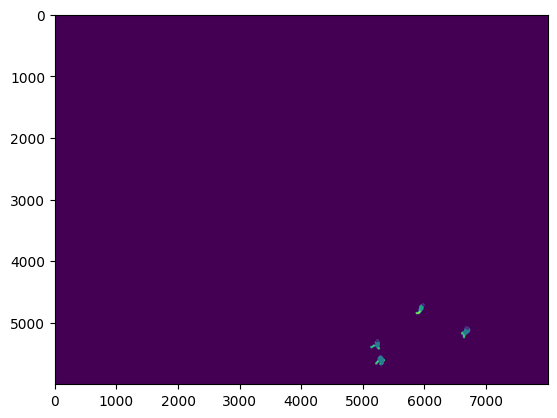

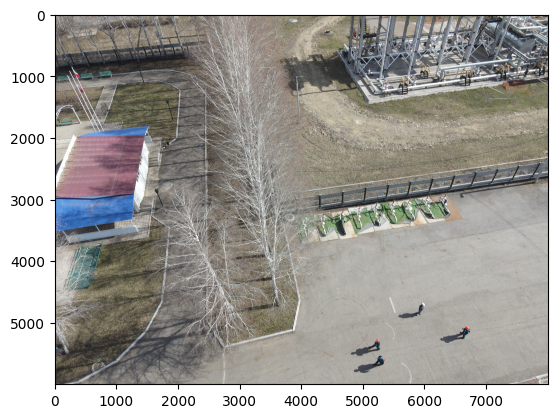

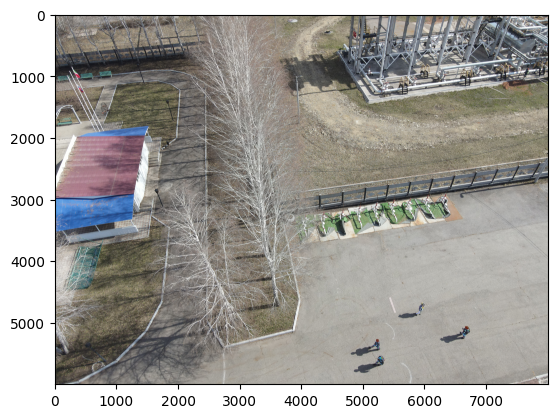

In [15]:




img_id = 9

print(coco.imgs[img_id]['file_name'])
img = cv2.imread(f'{yolo_path}/images/{train_val}/'+coco.imgs[img_id]['file_name'])

# Get annotations for current image
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)
# Create binary mask for each annotation
if anns:
    mask = coco.annToMask(anns[0])
    for i in range(len(anns)):
        m = coco.annToMask(anns[i])
        mask[m>0] = anns[i]['category_id']
        print(anns[i]['category_id'])

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(mask)
print(np.unique(mask))
plt.show()
plt.imshow(img)
plt.show()
plt.imshow(apply_mask(np.array(img), mask, (255,0,0)))
